In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding="same")(ip)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding="same")(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)

    return add([ip, res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

# Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers, temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

# Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides=strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)

    disc_model = LeakyReLU(alpha=0.2)(disc_model)

    return disc_model

# Descriminator as described in the original paper
def create_disc(disc_ip):
    
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation="sigmoid")(d10)

    return Model(disc_ip, validity)

# VGG19 for the feature map

from keras.applications import VGG19

def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

# Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    # losses from generated image and vgg features
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)

    # load generated images into discriminator
    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

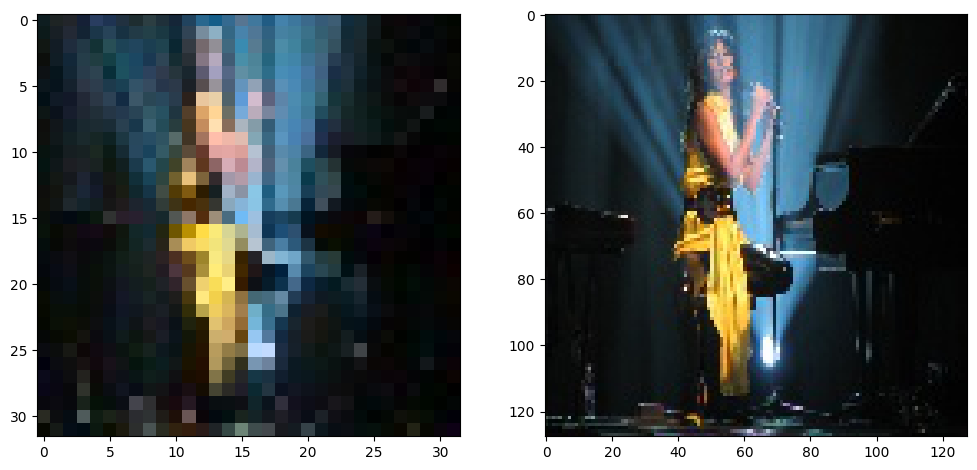

In [3]:
# load the datasets
n=5000
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("data/hr_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

# sanity check, view random images
import random

image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32,32,3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128,128,3)))
plt.show()

In [5]:
# scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

# spit to train and test set
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

# get shape of images
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [6]:
# Generator
generator = create_gen(lr_ip, num_res_block=16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [7]:
# Discriminator
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [8]:
vgg = build_vgg((128,128,3))
vgg.trainable = False
print(vgg.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [9]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [10]:
# create a list of images for LR and HR in batches from which
# a batch of images would be fetched during training
batch_size = 1
train_lr_batches = []
train_hr_batches = []

for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [11]:
epochs = 5
# Enumerate training over epochs
for e in range(epochs):

    # assign a label of 0 to all fake (generated) images
    fake_label = np.zeros((batch_size, 1))
    # assign a label of 1 to all real images
    real_label = np.ones((batch_size,1))

    # create empty lists to populate generator and discriminator losses
    g_losses = []
    d_losses = []

    # Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        # Fetch a batch of LR images for training
        lr_imgs = train_lr_batches[b]
        # Fetch a batch of HR images for training
        hr_imgs = train_hr_batches[b]

        # Generated fake images
        fake_imgs = generator.predict_on_batch(lr_imgs) 

        # First, train the discriminator on fake and real HR images
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        # Now, train the generator by fixing the discriminator as non-trainable
        discriminator.trainable = False
        
        # Average the discriminator loss, just for reporting purposes
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        # Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        # Train the generator via GAN
        # remember we have 2 losses
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        # save losses to a list so we can average and report
        g_losses.append(g_loss)
        d_losses.append(d_loss)

    # convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    # calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    # report the progess during training
    print("epoch:", e+1,"g_loss:", g_loss, "d_loss:", d_loss)

    # save the model after every n epochs (10)
    if (e+1) % 10 == 0:
        generator.save("gen_e_" + str(e+1) + ".h5")

  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 131ms/step


  0%|          | 1/3350 [00:07<7:25:36,  7.98s/it]

1/1 [==============================] - 0s 32ms/step


  0%|          | 2/3350 [00:08<3:35:00,  3.85s/it]

1/1 [==============================] - 0s 28ms/step


  0%|          | 3/3350 [00:09<2:21:10,  2.53s/it]

1/1 [==============================] - 0s 32ms/step


  0%|          | 4/3350 [00:10<1:48:07,  1.94s/it]

1/1 [==============================] - 0s 42ms/step


  0%|          | 5/3350 [00:11<1:29:56,  1.61s/it]

1/1 [==============================] - 0s 33ms/step


  0%|          | 6/3350 [00:12<1:18:27,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


  0%|          | 7/3350 [00:13<1:10:44,  1.27s/it]

1/1 [==============================] - 0s 32ms/step


  0%|          | 8/3350 [00:14<1:06:02,  1.19s/it]

1/1 [==============================] - 0s 32ms/step


  0%|          | 9/3350 [00:15<1:02:16,  1.12s/it]

1/1 [==============================] - 0s 35ms/step


  0%|          | 10/3350 [00:17<1:01:44,  1.11s/it]

1/1 [==============================] - 0s 37ms/step


  0%|          | 11/3350 [00:18<1:01:56,  1.11s/it]

1/1 [==============================] - 0s 38ms/step


  0%|          | 12/3350 [00:19<1:01:36,  1.11s/it]

1/1 [==============================] - 0s 41ms/step


  0%|          | 13/3350 [00:20<1:01:57,  1.11s/it]

1/1 [==============================] - 0s 35ms/step


  0%|          | 14/3350 [00:21<1:00:44,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


  0%|          | 15/3350 [00:22<58:38,  1.06s/it]  

1/1 [==============================] - 0s 31ms/step


  0%|          | 16/3350 [00:23<57:43,  1.04s/it]

1/1 [==============================] - 0s 31ms/step


  1%|          | 17/3350 [00:24<57:17,  1.03s/it]

1/1 [==============================] - 0s 31ms/step


  1%|          | 18/3350 [00:25<55:52,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 19/3350 [00:26<55:04,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 20/3350 [00:27<55:49,  1.01s/it]

1/1 [==============================] - 0s 34ms/step


  1%|          | 21/3350 [00:28<56:12,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


  1%|          | 22/3350 [00:29<58:01,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


  1%|          | 23/3350 [00:30<57:37,  1.04s/it]

1/1 [==============================] - 0s 31ms/step


  1%|          | 24/3350 [00:31<56:59,  1.03s/it]

1/1 [==============================] - 0s 36ms/step


  1%|          | 25/3350 [00:32<56:28,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  1%|          | 26/3350 [00:33<56:55,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 27/3350 [00:34<56:45,  1.02s/it]

1/1 [==============================] - 0s 36ms/step


  1%|          | 28/3350 [00:35<56:56,  1.03s/it]

1/1 [==============================] - 0s 28ms/step


  1%|          | 29/3350 [00:36<56:23,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 30/3350 [00:37<56:10,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  1%|          | 31/3350 [00:38<55:49,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 32/3350 [00:39<55:30,  1.00s/it]

1/1 [==============================] - 0s 34ms/step


  1%|          | 33/3350 [00:40<56:02,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 34/3350 [00:41<55:42,  1.01s/it]

1/1 [==============================] - 0s 35ms/step


  1%|          | 35/3350 [00:42<55:57,  1.01s/it]

1/1 [==============================] - 0s 35ms/step


  1%|          | 36/3350 [00:43<56:31,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  1%|          | 37/3350 [00:44<56:37,  1.03s/it]

1/1 [==============================] - 0s 35ms/step


  1%|          | 38/3350 [00:45<56:10,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 39/3350 [00:46<56:42,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 40/3350 [00:47<55:57,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  1%|          | 41/3350 [00:48<55:31,  1.01s/it]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 42/3350 [00:49<55:30,  1.01s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 43/3350 [00:50<56:55,  1.03s/it]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 44/3350 [00:51<57:56,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 45/3350 [00:52<57:02,  1.04s/it]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 46/3350 [00:54<58:02,  1.05s/it]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 47/3350 [00:55<59:58,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 48/3350 [00:56<57:17,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 49/3350 [00:57<56:05,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 50/3350 [00:58<55:58,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 51/3350 [00:59<54:41,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 52/3350 [01:00<55:47,  1.02s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 53/3350 [01:01<56:11,  1.02s/it]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 54/3350 [01:02<55:24,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 55/3350 [01:03<55:03,  1.00s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 56/3350 [01:04<55:13,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 57/3350 [01:05<54:37,  1.00it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 58/3350 [01:06<55:47,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 59/3350 [01:07<55:03,  1.00s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 60/3350 [01:08<55:06,  1.01s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 61/3350 [01:09<55:04,  1.00s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 62/3350 [01:10<55:52,  1.02s/it]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 63/3350 [01:11<56:33,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 64/3350 [01:12<1:02:05,  1.13s/it]


KeyboardInterrupt: 

In [6]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print(tf.__version__)

3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
2.10.0
